In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# 設定超參數

In [3]:
DATASET_NAME = 'AIMango'
PRETRAINED_MOEL_NAME = 'VGG16'

# Dataset Path Settings
TRAIN_PATH = 'data/' + DATASET_NAME + '/train/'
TEST_PATH = 'data/' + DATASET_NAME + '/test/'

# Save Path Settings，需建立資料夾
SAVE_TO_DIR = 'data/' + DATASET_NAME + '/generated' # For saving the augmented pictures being generated
MODEL_DIR = 'model/' + DATASET_NAME + '/' + PRETRAINED_MOEL_NAME
FEATURES_TRAIN_PATH_Xception = MODEL_DIR + '/features_train_Xception.npy' # 訓練用
FEATURES_TRAIN_PATH_VGG16 = MODEL_DIR + '/features_train_VGG16.npy'
FEATURES_TRAIN_PATH_MobileNet = MODEL_DIR + '/features_train_MobileNet.npy'
FEATURES_TRAIN_PATH_InceptionV3 = MODEL_DIR + '/features_train_InceptionV3.npy'
FEATURES_TRAIN_PATH_InceptionResNetV2 = MODEL_DIR + '/features_train_InceptionResNetV2.npy'
FEATURES_TRAIN_PATH_DenseNet121 = MODEL_DIR + '/features_train_DenseNet121.npy'

FEATURES_VALIDATION_PATH_Xception = MODEL_DIR + '/features_validation_Xception.npy' # 驗證用
FEATURES_VALIDATION_PATH_VGG16 = MODEL_DIR + '/features_validation_VGG16.npy' 
FEATURES_VALIDATION_PATH_MobileNet = MODEL_DIR + '/features_validation_MobileNet.npy' 
FEATURES_VALIDATION_PATH_InceptionV3 = MODEL_DIR + '/features_validation_InceptionV3.npy' 
FEATURES_VALIDATION_PATH_InceptionResNetV2 = MODEL_DIR + '/features_validation_InceptionResNetV2.npy' 
FEATURES_VALIDATION_PATH_DenseNet121 = MODEL_DIR + '/features_validation_DenseNet121.npy' 

CLASS_DICTIONARY_PATH_Xception = MODEL_DIR + '/class_indices_Xception.npy' # features_train 的 class label
CLASS_DICTIONARY_PATH_VGG16 = MODEL_DIR + '/class_indices_VGG16.npy'
CLASS_DICTIONARY_PATH_MobileNet = MODEL_DIR + '/class_indices_MobileNet.npy'
CLASS_DICTIONARY_PATH_InceptionV3 = MODEL_DIR + '/class_indices_InceptionV3.npy'
CLASS_DICTIONARY_PATH_InceptionResNetV2 = MODEL_DIR + '/class_indices_InceptionResNetV2.npy'
CLASS_DICTIONARY_PATH_DenseNet121 = MODEL_DIR + '/class_indices_DenseNet121.npy'

MODEL_SAVE_PATH_Xception = MODEL_DIR + '/Xception_model.h5'
MODEL_SAVE_PATH_VGG16 = MODEL_DIR + '/VGG16_model.h5'
MODEL_SAVE_PATH_MobileNet = MODEL_DIR + '/MobileNet_model.h5'
MODEL_SAVE_PATH_InceptionV3 = MODEL_DIR + '/InceptionV3_model.h5'
MODEL_SAVE_PATH_InceptionResNetV2 = MODEL_DIR + '/InceptionResNetV2_model.h5'
MODEL_SAVE_PATH_DenseNet121 = MODEL_DIR + '/DenseNet121_model.h5'

# Hyperparameter Settings
img_width, img_height = 224, 224 # 圖片大小
batch_size = 32
epochs = 10000
learning_rate = 2e-5
momentum = 0.9
early_stop_count = 10

# 資料預處理

In [4]:
# import os
# import shutil
# import csv

# BASE_PATH = 'C1-P1_Train Dev_fixed/'
# LABEL_FILE = BASE_PATH + 'train.csv'
# IMAGE_FOLDER = BASE_PATH + 'data-segmentation/C1-P1_Train/' # 圖片所在資料夾
# IMAGE_NUMBER = 5600 # 資料夾中圖片數量
# TRAIN_DATA_RATIO = 0.8 # 拆分訓練資料比例

# # 建立資料夾
# target = TRAIN_PATH
# if os.path.exists(target):
#     shutil.rmtree(target)
# os.makedirs(target)

# target = TEST_PATH
# if os.path.exists(target):
#     shutil.rmtree(target)
# os.makedirs(target)

# target = SAVE_TO_DIR
# if os.path.exists(target):
#     shutil.rmtree(target)
# os.makedirs(target)

# target = MODEL_DIR
# if os.path.exists(target):
#     shutil.rmtree(target)
# os.makedirs(target)

# # 建立圖片分類資料夾
# for imageClass in ['A', 'B', 'C']:
#     target = TRAIN_PATH + imageClass + '/'
#     if os.path.exists(target):
#         shutil.rmtree(target)
#     os.makedirs(target)
    
#     target = TEST_PATH + imageClass + '/'
#     if os.path.exists(target):
#         shutil.rmtree(target)
#     os.makedirs(target)

# # util
# def copyfile(fromPath, toPath): 
#     old_path = os.path.join(fromPath)
#     new_path = os.path.join(toPath)
#     shutil.copy(old_path, new_path)

# # start copy
# with open(LABEL_FILE, newline='\n') as csvfile:
#     rows = csv.reader(csvfile)
    
#     i = 0
#     train_data_number = IMAGE_NUMBER * TRAIN_DATA_RATIO # 訓練資料數量
#     for row in rows:
#         if (row[0] != 'image_id'):
#             fromPath = IMAGE_FOLDER + row[0]
#             if i < train_data_number:
#                 toPath = TRAIN_PATH + row[1] + '/'
#                 copyfile(fromPath, toPath)
#             else:
#                 toPath = TEST_PATH + row[1] + '/'
#                 copyfile(fromPath, toPath)
#             i += 1
#             print('目前做了 ' + str(i) + '筆')

# Xception - Save Features 

In [10]:
#
# Base model
#
model_Xception = applications.Xception(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_Xception.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_Xception, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_Xception, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_Xception.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_Xception, features_validation)

Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# Xception - Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 25,691,139
Trainable params: 25,691,139
Non-trainable params: 0
_________________________________________________________________
Train on 3585 samples, validate on 895 samples
Epoch 1/10000
3585/3585 [==============================] - 9s 2ms/step - loss: 0.8771 - acc: 0.5989 - val_loss: 0.7835 - val_acc: 0.6391

Epoch 00001: val_loss improved from inf to 0.78349, saving model to model/AIM

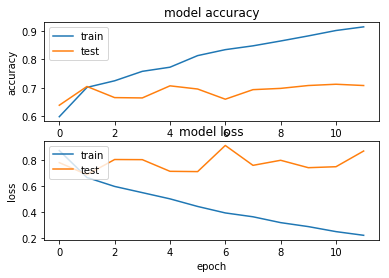

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_Xception)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_Xception)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_Xception = Sequential()
model_Xception.add(Flatten(input_shape=train_data.shape[1:]))
model_Xception.add(Dense(256, activation='relu'))
model_Xception.add(Dropout(0.5))
model_Xception.add(Dense(num_classes, activation='softmax'))


model_Xception.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Xception.summary()


early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_Xception, verbose=1, save_best_only=True)

# training model
history = model_Xception.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_Xception.save_weights(MODEL_SAVE_PATH_Xception)



# evaluate
(eval_loss, eval_accuracy) = model_Xception.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# VGG16 - Save Features

In [13]:
#
# Base model
#
model_VGG16 = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_VGG16.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_VGG16, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_VGG16, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_VGG16.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_VGG16, features_validation)

Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# VGG16 - Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 6,423,555
Trainable params: 6,423,555
Non-trainable params: 0
_________________________________________________________________
Train on 3585 samples, validate on 895 samples
Epoch 1/10000
3585/3585 [==============================] - 6s 2ms/step - loss: 1.0450 - acc: 0.4773 - val_loss: 0.9124 - val_acc: 0.5274

Epoch 00001: val_loss improved from inf to 0.91238, saving model to model/AIMan

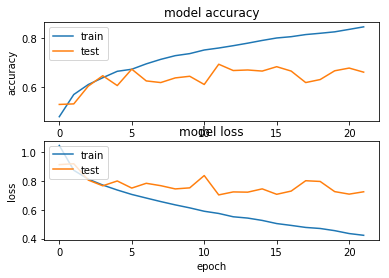

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_VGG16)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_VGG16)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_VGG16 = Sequential()
model_VGG16.add(Flatten(input_shape=train_data.shape[1:]))
model_VGG16.add(Dense(256, activation='relu'))
model_VGG16.add(Dropout(0.5))
model_VGG16.add(Dense(num_classes, activation='softmax'))


model_VGG16.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_VGG16.summary()

early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_VGG16, verbose=1, save_best_only=True)

# training model
history = model_VGG16.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_VGG16.save_weights(MODEL_SAVE_PATH_VGG16)

# evaluate
(eval_loss, eval_accuracy) = model_VGG16.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# MobileNet - Save Features

In [14]:
#
# Base model
#
model_MobileNet = applications.MobileNet(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_MobileNet.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_MobileNet, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_MobileNet, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_MobileNet.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_MobileNet, features_validation)

D:\conda\lib\site-packages\keras\applications\mobilenet.py:224: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# MobileNet - Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 12,846,083
Trainable params: 12,846,083
Non-trainable params: 0
_________________________________________________________________
Train on 3585 samples, validate on 895 samples
Epoch 1/10000
3585/3585 [==============================] - 6s 2ms/step - loss: 1.1269 - acc: 0.5476 - val_loss: 0.7565 - val_acc: 0.6536

Epoch 00001: val_loss improved from inf to 0.75651, saving model to model/AIM

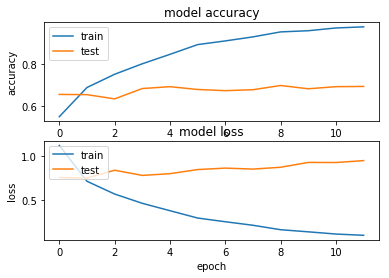

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_MobileNet)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_MobileNet)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_MobileNet = Sequential()
model_MobileNet.add(Flatten(input_shape=train_data.shape[1:]))
model_MobileNet.add(Dense(256, activation='relu'))
model_MobileNet.add(Dropout(0.5))
model_MobileNet.add(Dense(num_classes, activation='softmax'))


model_MobileNet.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_MobileNet.summary()



early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_MobileNet, verbose=1, save_best_only=True)

# training model
history = model_MobileNet.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_MobileNet.save_weights(MODEL_SAVE_PATH_MobileNet)

# evaluate
(eval_loss, eval_accuracy) = model_MobileNet.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# InceptionV3 - Save Features

In [16]:
#
# Base model
#
model_InceptionV3 = applications.InceptionV3(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_InceptionV3.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_InceptionV3, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_InceptionV3, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_InceptionV3.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_InceptionV3, features_validation)


Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# InceptionV3 - Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 771       
Total params: 13,108,227
Trainable params: 13,108,227
Non-trainable params: 0
_________________________________________________________________
Train on 3585 samples, validate on 895 samples
Epoch 1/10000
3585/3585 [==============================] - 7s 2ms/step - loss: 1.0650 - acc: 0.5372 - val_loss: 0.7779 - val_acc: 0.6436

Epoch 00001: val_loss improved from inf to 0.77792, saving model to model/AIM

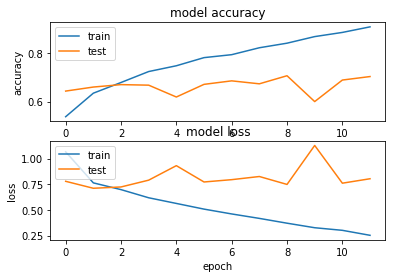

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_InceptionV3)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_InceptionV3)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_InceptionV3 = Sequential()
model_InceptionV3.add(Flatten(input_shape=train_data.shape[1:]))
model_InceptionV3.add(Dense(256, activation='relu'))
model_InceptionV3.add(Dropout(0.5))
model_InceptionV3.add(Dense(num_classes, activation='softmax'))


model_InceptionV3.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_InceptionV3.summary()



early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_InceptionV3, verbose=1, save_best_only=True)

# training model
history = model_InceptionV3.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_InceptionV3.save_weights(MODEL_SAVE_PATH_InceptionV3)

# evaluate
(eval_loss, eval_accuracy) = model_InceptionV3.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# InceptionResNetV2 - Save Features

In [18]:
#
# Base model
#
model_InceptionResNetV2 = applications.InceptionResNetV2(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_InceptionResNetV2.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_InceptionResNetV2, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_InceptionResNetV2, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_InceptionResNetV2.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_InceptionResNetV2, features_validation)

Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# InceptionResNetV2 - Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 771       
Total params: 9,831,427
Trainable params: 9,831,427
Non-trainable params: 0
_________________________________________________________________
Train on 3585 samples, validate on 895 samples
Epoch 1/10000
3585/3585 [==============================] - 7s 2ms/step - loss: 1.0998 - acc: 0.5431 - val_loss: 0.8538 - val_acc: 0.5911

Epoch 00001: val_loss improved from inf to 0.85375, saving model to model/AIMan

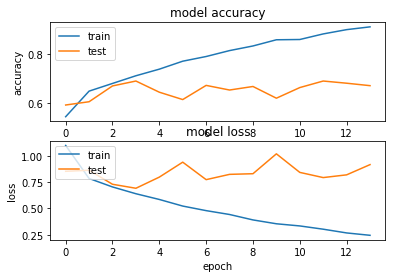

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_InceptionResNetV2)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_InceptionResNetV2)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_InceptionResNetV2 = Sequential()
model_InceptionResNetV2.add(Flatten(input_shape=train_data.shape[1:]))
model_InceptionResNetV2.add(Dense(256, activation='relu'))
model_InceptionResNetV2.add(Dropout(0.5))
model_InceptionResNetV2.add(Dense(num_classes, activation='softmax'))


model_InceptionResNetV2.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_InceptionResNetV2.summary()



early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_InceptionResNetV2, verbose=1, save_best_only=True)

# training model
history = model_InceptionResNetV2.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_InceptionResNetV2.save_weights(MODEL_SAVE_PATH_InceptionResNetV2)

# evaluate
(eval_loss, eval_accuracy) = model_InceptionResNetV2.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# DenseNet121 - Save Features

In [4]:
#
# Base model
#
model_DenseNet121 = applications.DenseNet121(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=0.5,
    validation_split=0.2)

# 
# Train ImageDataGenerator
# 
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
#     save_to_dir=SAVE_TO_DIR, # For saving the augmented pictures being generated
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False)#不要隨機

num_train_samples = len(train_generator.filenames) # 訓練資料數量
num_classes = len(train_generator.class_indices) # 類別數量
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices) # 類別名稱、index

predict_size_train = int(math.ceil(num_train_samples / batch_size)) # 每次epoch會修改的權重次數

# predict_generator : Generates predictions for the input samples from a data generator.
# 先將圖片透過 VGG16 pretrained model 產生一個 high level 的 feature map，之後會用此圖片重要特徵做 fine-tune
features_train = model_DenseNet121.predict_generator(train_generator, predict_size_train)
np.save(FEATURES_TRAIN_PATH_DenseNet121, features_train)

# 將 class name (人的 ID ) 及對應的 index 存起來
np.save(CLASS_DICTIONARY_PATH_DenseNet121, train_generator.class_indices) 


# 
# Validation ImageDataGenerator
# 
train_generator.reset()

validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

predict_size_validation = int(math.ceil(num_validation_samples / batch_size))

features_validation = model_DenseNet121.predict_generator(validation_generator, predict_size_validation)
np.save(FEATURES_VALIDATION_PATH_DenseNet121, features_validation)









Found 3585 images belonging to 3 classes.
訓練資料的數量 =>  3585
類別數量 =>  3
類別名稱、index =>  {'A': 0, 'B': 1, 'C': 2}
Found 895 images belonging to 3 classes.
驗證資料的數量 =>  895


# DenseNet121 - Train

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 12,846,083
Trainable params: 12,846,083
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3585 samples, validate on 895 samples
Epoch

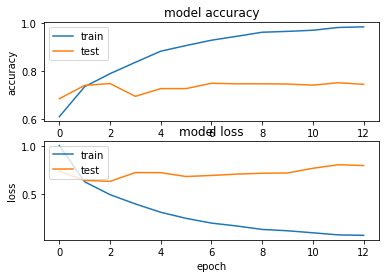

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

# train data
train_data = np.load(FEATURES_TRAIN_PATH_DenseNet121)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation data
validation_data = np.load(FEATURES_VALIDATION_PATH_DenseNet121)
validation_labels = validation_generator.classes
validation_labels = to_categorical(
    validation_labels, num_classes=num_classes)

# build model
model_DenseNet121 = Sequential()
model_DenseNet121.add(Flatten(input_shape=train_data.shape[1:]))
model_DenseNet121.add(Dense(256, activation='relu'))
model_DenseNet121.add(Dropout(0.5))
model_DenseNet121.add(Dense(num_classes, activation='softmax'))


model_DenseNet121.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_DenseNet121.summary()



early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH_DenseNet121, verbose=1, save_best_only=True)

# training model
history = model_DenseNet121.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpointer], 
                    validation_data=(validation_data, validation_labels))

# save model
model_DenseNet121.save_weights(MODEL_SAVE_PATH_DenseNet121)

# evaluate
(eval_loss, eval_accuracy) = model_DenseNet121.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)#1行2列(row,column)，當前位置為1
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)#1行2列(row,column)，當前位置為2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [4]:
# FOR TEST
import os
IMAGE_FOLDER_NAME = 'C1-P1_Test' # 圖片資料夾
target_directory = 'C1-P1_Train Dev_fixed/data-segmentation/' + IMAGE_FOLDER_NAME

## Xception

In [6]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_Xception).item()
num_classes = len(class_dictionary)

# build the VGG16 network
pretrained_model = applications.Xception(include_top=False, weights='imagenet')
train_data = np.load(FEATURES_TRAIN_PATH_Xception)

# build top model
model_Xception = Sequential()
model_Xception.add(Flatten(input_shape=train_data.shape[1:]))
model_Xception.add(Dense(256, activation='relu'))
model_Xception.add(Dropout(0.5))
model_Xception.add(Dense(num_classes, activation='softmax'))

model_Xception.load_weights(MODEL_SAVE_PATH_Xception)

# 
# Step 2 : Predict
# 
result_Xception = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_Xception.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_Xception.append([file, label])

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
00001.jpg, C
00006.jpg, B
00011.jpg, B
00016.jpg, A
00025.jpg, C
00028.jpg, C
00034.jpg, A
00035.jpg, B
00042.jpg, A
00043.jpg, B
00046.jpg, C
00066.jpg, A
00074.jpg, C
00079.jpg, C
00083.jpg, B
00088.jpg, A
00090.jpg, A
00095.jpg, C
00098.jpg, B
00106.jpg, B
00114.jpg, B
00120.jpg, C
00124.jpg, A
00135.jpg, B
00137.jpg, A
00138.jpg, A
00146.jpg, C
00151.jpg, C
00155.jpg, C
00156.jpg, A
00159.jpg, B
00168.jpg, B
00169.jpg, C
00173.jpg, A
00182.jpg, C
00185.jpg, B
00186.jpg, A
00188.jpg, C
00196.jpg, C
00207.jpg, B
00216.jpg, B
00220.jpg, B
00221.jpg, C
00222.jpg, A
00237.jpg, B
00238.jpg, A
00239.jpg, C
00241.jpg, B
00247.jpg, B
00250.jpg, C
00255.jpg, B
00257.jpg, A
00258.jpg, A
00262.jpg, B
00264.jpg, C
00270.jpg, B
00276.jpg, B
00277.jpg, B
00278.jpg, B
00279.jpg, C
00284.jpg, A
00286.jpg, B
00288.jpg, A
00290.jpg, C
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, A
0

03018.jpg, C
03027.jpg, C
03030.jpg, C
03036.jpg, C
03038.jpg, C
03042.jpg, A
03052.jpg, B
03053.jpg, C
03058.jpg, B
03063.jpg, A
03073.jpg, C
03085.jpg, A
03086.jpg, C
03087.jpg, C
03088.jpg, A
03089.jpg, C
03095.jpg, B
03107.jpg, B
03109.jpg, C
03111.jpg, A
03122.jpg, B
03123.jpg, A
03131.jpg, A
03132.jpg, A
03133.jpg, B
03149.jpg, A
03155.jpg, A
03157.jpg, A
03164.jpg, C
03166.jpg, B
03171.jpg, B
03175.jpg, B
03179.jpg, C
03183.jpg, A
03186.jpg, B
03188.jpg, C
03201.jpg, C
03204.jpg, A
03205.jpg, C
03206.jpg, C
03207.jpg, C
03214.jpg, C
03221.jpg, B
03222.jpg, B
03231.jpg, C
03242.jpg, B
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, C
03271.jpg, C
03274.jpg, A
03277.jpg, A
03279.jpg, C
03284.jpg, C
03290.jpg, A
03292.jpg, B
03296.jpg, B
03306.jpg, A
03347.jpg, A
03348.jpg, B
03350.jpg, C
03353.jpg, C
03355.jpg, C
03357.jpg, B
03359.jpg, A
03365.jpg, B
03366.jpg, A
03370.jpg, C
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, C
03397.jpg, C
03398.jpg, B
03403.jpg, B
03408.jpg, A

## VGG16

In [29]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_VGG16).item()
num_classes = len(class_dictionary)
train_data = np.load(FEATURES_TRAIN_PATH_VGG16)


# build the VGG16 network
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')

# build top model
model_VGG16 = Sequential()
model_VGG16.add(Flatten(input_shape=train_data.shape[1:]))
model_VGG16.add(Dense(256, activation='relu'))
model_VGG16.add(Dropout(0.5))
model_VGG16.add(Dense(num_classes, activation='softmax'))

model_VGG16.load_weights(MODEL_SAVE_PATH_VGG16)

# 
# Step 2 : Predict
# 
result_VGG16 = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_VGG16.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_VGG16.append(label)

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



00001.jpg, C
00006.jpg, A
00011.jpg, B
00016.jpg, A
00025.jpg, C
00028.jpg, B
00034.jpg, A
00035.jpg, B
00042.jpg, A
00043.jpg, B
00046.jpg, A
00066.jpg, A
00074.jpg, C
00079.jpg, B
00083.jpg, B
00088.jpg, A
00090.jpg, B
00095.jpg, C
00098.jpg, A
00106.jpg, B
00114.jpg, B
00120.jpg, B
00124.jpg, A
00135.jpg, B
00137.jpg, A
00138.jpg, B
00146.jpg, B
00151.jpg, C
00155.jpg, C
00156.jpg, B
00159.jpg, B
00168.jpg, B
00169.jpg, C
00173.jpg, A
00182.jpg, B
00185.jpg, B
00186.jpg, B
00188.jpg, C
00196.jpg, B
00207.jpg, B
00216.jpg, A
00220.jpg, B
00221.jpg, B
00222.jpg, A
00237.jpg, B
00238.jpg, B
00239.jpg, C
00241.jpg, B
00247.jpg, B
00250.jpg, C
00255.jpg, B
00257.jpg, B
00258.jpg, A
00262.jpg, A
00264.jpg, C
00270.jpg, B
00276.jpg, B
00277.jpg, B
00278.jpg, C
00279.jpg, B
00284.jpg, A
00286.jpg, A
00288.jpg, B
00290.jpg, B
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, B
00317.jpg, A
00327.jpg, B
00332.jpg, B
00333.jpg, B
00334.jpg, A
00337.jpg, C
00339.jpg, A
00343.jpg, B
00347.jpg, B

03164.jpg, A
03166.jpg, B
03171.jpg, B
03175.jpg, C
03179.jpg, B
03183.jpg, A
03186.jpg, B
03188.jpg, C
03201.jpg, A
03204.jpg, A
03205.jpg, B
03206.jpg, B
03207.jpg, C
03214.jpg, B
03221.jpg, B
03222.jpg, B
03231.jpg, C
03242.jpg, A
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, C
03271.jpg, B
03274.jpg, B
03277.jpg, A
03279.jpg, B
03284.jpg, B
03290.jpg, A
03292.jpg, B
03296.jpg, B
03306.jpg, A
03347.jpg, A
03348.jpg, B
03350.jpg, B
03353.jpg, C
03355.jpg, C
03357.jpg, B
03359.jpg, A
03365.jpg, B
03366.jpg, B
03370.jpg, B
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, B
03397.jpg, B
03398.jpg, B
03403.jpg, B
03408.jpg, A
03410.jpg, B
03413.jpg, A
03419.jpg, B
03421.jpg, A
03422.jpg, A
03427.jpg, B
03429.jpg, B
03446.jpg, C
03447.jpg, C
03448.jpg, B
03460.jpg, B
03465.jpg, B
03475.jpg, B
03478.jpg, C
03479.jpg, B
03480.jpg, A
03483.jpg, C
03484.jpg, B
03489.jpg, B
03495.jpg, C
03508.jpg, C
03515.jpg, B
03520.jpg, B
03523.jpg, C
03524.jpg, B
03530.jpg, B
03531.jpg, B
03535.jpg, C

06308.jpg, B
06313.jpg, C
06320.jpg, A
06328.jpg, B
06329.jpg, A
06336.jpg, A
06337.jpg, B
06342.jpg, B
06345.jpg, B
06346.jpg, A
06347.jpg, B
06350.jpg, B
06351.jpg, A
06352.jpg, A
06354.jpg, A
06355.jpg, B
06371.jpg, C
06373.jpg, A
06374.jpg, B
06376.jpg, B
06382.jpg, A
06383.jpg, C
06385.jpg, B
06393.jpg, B
06395.jpg, B
06400.jpg, C
06408.jpg, C
06410.jpg, B
06432.jpg, C
06442.jpg, B
06443.jpg, B
06445.jpg, B
06447.jpg, B
06449.jpg, C
06452.jpg, B
06453.jpg, B
06459.jpg, B
06467.jpg, A
06478.jpg, B
06484.jpg, A
06487.jpg, C
06493.jpg, C
06494.jpg, B
06498.jpg, C
06502.jpg, A
06506.jpg, B
06512.jpg, A
06514.jpg, C
06523.jpg, A
06524.jpg, B
06530.jpg, A
06532.jpg, A
06533.jpg, C
06546.jpg, B
06549.jpg, C
06550.jpg, B
06552.jpg, C
06561.jpg, B
06562.jpg, B
06567.jpg, B
06569.jpg, B
06575.jpg, C
06577.jpg, B
06580.jpg, C
06581.jpg, B
06583.jpg, C
06584.jpg, A
06585.jpg, B
06594.jpg, C
06618.jpg, C
06619.jpg, A
06624.jpg, B
06635.jpg, B
06637.jpg, B
06640.jpg, C
06645.jpg, B
06655.jpg, B

## MobileNet

In [32]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_MobileNet).item()
num_classes = len(class_dictionary)
train_data = np.load(FEATURES_TRAIN_PATH_MobileNet)

# build the VGG16 network
pretrained_model = applications.MobileNet(include_top=False, weights='imagenet')

# build top model
model_MobileNet = Sequential()
model_MobileNet.add(Flatten(input_shape=train_data.shape[1:]))
model_MobileNet.add(Dense(256, activation='relu'))
model_MobileNet.add(Dropout(0.5))
model_MobileNet.add(Dense(num_classes, activation='softmax'))

model_MobileNet.load_weights(MODEL_SAVE_PATH_MobileNet)

# 
# Step 2 : Predict
# 
result_MobileNet = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_MobileNet.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_MobileNet.append(label)

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



00001.jpg, C
00006.jpg, B
00011.jpg, A
00016.jpg, A
00025.jpg, C
00028.jpg, C
00034.jpg, A
00035.jpg, B
00042.jpg, A
00043.jpg, B
00046.jpg, B
00066.jpg, A
00074.jpg, C
00079.jpg, B
00083.jpg, A
00088.jpg, B
00090.jpg, A
00095.jpg, C
00098.jpg, A
00106.jpg, B
00114.jpg, A
00120.jpg, B
00124.jpg, A
00135.jpg, A
00137.jpg, A
00138.jpg, A
00146.jpg, B
00151.jpg, C
00155.jpg, C
00156.jpg, A
00159.jpg, B
00168.jpg, B
00169.jpg, C
00173.jpg, A
00182.jpg, A
00185.jpg, B
00186.jpg, A
00188.jpg, C
00196.jpg, C
00207.jpg, B
00216.jpg, B
00220.jpg, C
00221.jpg, C
00222.jpg, A
00237.jpg, B
00238.jpg, A
00239.jpg, C
00241.jpg, B
00247.jpg, A
00250.jpg, C
00255.jpg, B
00257.jpg, A
00258.jpg, A
00262.jpg, A
00264.jpg, C
00270.jpg, A
00276.jpg, B
00277.jpg, B
00278.jpg, C
00279.jpg, C
00284.jpg, A
00286.jpg, A
00288.jpg, A
00290.jpg, C
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, A
00317.jpg, A
00327.jpg, B
00332.jpg, B
00333.jpg, A
00334.jpg, A
00337.jpg, C
00339.jpg, A
00343.jpg, B
00347.jpg, A

03157.jpg, A
03164.jpg, C
03166.jpg, A
03171.jpg, B
03175.jpg, B
03179.jpg, B
03183.jpg, A
03186.jpg, A
03188.jpg, C
03201.jpg, A
03204.jpg, A
03205.jpg, C
03206.jpg, B
03207.jpg, C
03214.jpg, A
03221.jpg, B
03222.jpg, A
03231.jpg, C
03242.jpg, B
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, B
03271.jpg, B
03274.jpg, B
03277.jpg, A
03279.jpg, C
03284.jpg, B
03290.jpg, A
03292.jpg, B
03296.jpg, B
03306.jpg, A
03347.jpg, A
03348.jpg, A
03350.jpg, B
03353.jpg, C
03355.jpg, C
03357.jpg, A
03359.jpg, A
03365.jpg, B
03366.jpg, A
03370.jpg, C
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, B
03397.jpg, C
03398.jpg, A
03403.jpg, B
03408.jpg, A
03410.jpg, C
03413.jpg, A
03419.jpg, C
03421.jpg, A
03422.jpg, A
03427.jpg, A
03429.jpg, A
03446.jpg, C
03447.jpg, C
03448.jpg, B
03460.jpg, A
03465.jpg, C
03475.jpg, B
03478.jpg, C
03479.jpg, C
03480.jpg, A
03483.jpg, C
03484.jpg, C
03489.jpg, B
03495.jpg, C
03508.jpg, C
03515.jpg, A
03520.jpg, B
03523.jpg, C
03524.jpg, A
03530.jpg, B
03531.jpg, C

06329.jpg, A
06336.jpg, A
06337.jpg, B
06342.jpg, B
06345.jpg, B
06346.jpg, B
06347.jpg, B
06350.jpg, B
06351.jpg, A
06352.jpg, A
06354.jpg, A
06355.jpg, B
06371.jpg, C
06373.jpg, A
06374.jpg, A
06376.jpg, B
06382.jpg, A
06383.jpg, C
06385.jpg, A
06393.jpg, A
06395.jpg, B
06400.jpg, C
06408.jpg, C
06410.jpg, A
06432.jpg, C
06442.jpg, B
06443.jpg, A
06445.jpg, C
06447.jpg, B
06449.jpg, C
06452.jpg, A
06453.jpg, B
06459.jpg, A
06467.jpg, A
06478.jpg, C
06484.jpg, B
06487.jpg, C
06493.jpg, C
06494.jpg, A
06498.jpg, C
06502.jpg, A
06506.jpg, B
06512.jpg, A
06514.jpg, C
06523.jpg, A
06524.jpg, B
06530.jpg, A
06532.jpg, B
06533.jpg, A
06546.jpg, A
06549.jpg, C
06550.jpg, C
06552.jpg, C
06561.jpg, B
06562.jpg, A
06567.jpg, A
06569.jpg, A
06575.jpg, A
06577.jpg, B
06580.jpg, B
06581.jpg, B
06583.jpg, C
06584.jpg, A
06585.jpg, B
06594.jpg, C
06618.jpg, C
06619.jpg, A
06624.jpg, B
06635.jpg, B
06637.jpg, A
06640.jpg, C
06645.jpg, B
06655.jpg, C
06663.jpg, B
06671.jpg, A
06672.jpg, A
06673.jpg, B

## InceptionV3

In [33]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_InceptionV3).item()
num_classes = len(class_dictionary)
train_data = np.load(FEATURES_TRAIN_PATH_InceptionV3)

# build the VGG16 network
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet')

# build top model
model_InceptionV3 = Sequential()
model_InceptionV3.add(Flatten(input_shape=train_data.shape[1:]))
model_InceptionV3.add(Dense(256, activation='relu'))
model_InceptionV3.add(Dropout(0.5))
model_InceptionV3.add(Dense(num_classes, activation='softmax'))

model_InceptionV3.load_weights(MODEL_SAVE_PATH_InceptionV3)

# 
# Step 2 : Predict
# 
result_InceptionV3 = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_InceptionV3.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_InceptionV3.append(label)

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



00001.jpg, C
00006.jpg, B
00011.jpg, B
00016.jpg, A
00025.jpg, C
00028.jpg, A
00034.jpg, A
00035.jpg, A
00042.jpg, A
00043.jpg, B
00046.jpg, B
00066.jpg, A
00074.jpg, C
00079.jpg, C
00083.jpg, A
00088.jpg, B
00090.jpg, A
00095.jpg, C
00098.jpg, A
00106.jpg, B
00114.jpg, A
00120.jpg, C
00124.jpg, A
00135.jpg, B
00137.jpg, A
00138.jpg, B
00146.jpg, B
00151.jpg, C
00155.jpg, C
00156.jpg, A
00159.jpg, B
00168.jpg, B
00169.jpg, C
00173.jpg, A
00182.jpg, A
00185.jpg, B
00186.jpg, A
00188.jpg, C
00196.jpg, C
00207.jpg, B
00216.jpg, B
00220.jpg, C
00221.jpg, C
00222.jpg, A
00237.jpg, B
00238.jpg, A
00239.jpg, C
00241.jpg, B
00247.jpg, B
00250.jpg, C
00255.jpg, B
00257.jpg, B
00258.jpg, A
00262.jpg, B
00264.jpg, C
00270.jpg, B
00276.jpg, B
00277.jpg, B
00278.jpg, B
00279.jpg, C
00284.jpg, B
00286.jpg, B
00288.jpg, A
00290.jpg, B
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, A
00317.jpg, A
00327.jpg, B
00332.jpg, A
00333.jpg, A
00334.jpg, A
00337.jpg, C
00339.jpg, A
00343.jpg, A
00347.jpg, A

03157.jpg, A
03164.jpg, C
03166.jpg, B
03171.jpg, B
03175.jpg, C
03179.jpg, C
03183.jpg, A
03186.jpg, A
03188.jpg, C
03201.jpg, A
03204.jpg, A
03205.jpg, C
03206.jpg, C
03207.jpg, C
03214.jpg, C
03221.jpg, B
03222.jpg, A
03231.jpg, C
03242.jpg, A
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, C
03271.jpg, C
03274.jpg, B
03277.jpg, A
03279.jpg, C
03284.jpg, C
03290.jpg, B
03292.jpg, B
03296.jpg, B
03306.jpg, B
03347.jpg, B
03348.jpg, A
03350.jpg, B
03353.jpg, C
03355.jpg, C
03357.jpg, A
03359.jpg, A
03365.jpg, B
03366.jpg, A
03370.jpg, C
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, C
03397.jpg, C
03398.jpg, A
03403.jpg, A
03408.jpg, A
03410.jpg, B
03413.jpg, B
03419.jpg, C
03421.jpg, A
03422.jpg, A
03427.jpg, C
03429.jpg, B
03446.jpg, C
03447.jpg, B
03448.jpg, C
03460.jpg, C
03465.jpg, C
03475.jpg, B
03478.jpg, C
03479.jpg, C
03480.jpg, A
03483.jpg, C
03484.jpg, C
03489.jpg, B
03495.jpg, C
03508.jpg, C
03515.jpg, B
03520.jpg, C
03523.jpg, C
03524.jpg, A
03530.jpg, C
03531.jpg, C

06302.jpg, A
06308.jpg, B
06313.jpg, C
06320.jpg, C
06328.jpg, A
06329.jpg, A
06336.jpg, A
06337.jpg, B
06342.jpg, B
06345.jpg, C
06346.jpg, B
06347.jpg, A
06350.jpg, B
06351.jpg, A
06352.jpg, A
06354.jpg, A
06355.jpg, B
06371.jpg, C
06373.jpg, A
06374.jpg, A
06376.jpg, B
06382.jpg, A
06383.jpg, C
06385.jpg, A
06393.jpg, A
06395.jpg, B
06400.jpg, C
06408.jpg, C
06410.jpg, B
06432.jpg, C
06442.jpg, B
06443.jpg, A
06445.jpg, B
06447.jpg, B
06449.jpg, B
06452.jpg, A
06453.jpg, C
06459.jpg, B
06467.jpg, A
06478.jpg, A
06484.jpg, A
06487.jpg, C
06493.jpg, C
06494.jpg, A
06498.jpg, C
06502.jpg, A
06506.jpg, C
06512.jpg, A
06514.jpg, C
06523.jpg, A
06524.jpg, B
06530.jpg, B
06532.jpg, B
06533.jpg, A
06546.jpg, A
06549.jpg, B
06550.jpg, B
06552.jpg, C
06561.jpg, B
06562.jpg, B
06567.jpg, B
06569.jpg, B
06575.jpg, C
06577.jpg, B
06580.jpg, B
06581.jpg, B
06583.jpg, C
06584.jpg, A
06585.jpg, B
06594.jpg, C
06618.jpg, C
06619.jpg, A
06624.jpg, A
06635.jpg, B
06637.jpg, A
06640.jpg, C
06645.jpg, A

## InceptionResNetV2

In [34]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_InceptionV3).item()
num_classes = len(class_dictionary)
train_data = np.load(FEATURES_TRAIN_PATH_InceptionResNetV2)

# build the VGG16 network
pretrained_model = applications.InceptionResNetV2(include_top=False, weights='imagenet')

# build top model
model_InceptionResNetV2 = Sequential()
model_InceptionResNetV2.add(Flatten(input_shape=train_data.shape[1:]))
model_InceptionResNetV2.add(Dense(256, activation='relu'))
model_InceptionResNetV2.add(Dropout(0.5))
model_InceptionResNetV2.add(Dense(num_classes, activation='softmax'))

model_InceptionResNetV2.load_weights(MODEL_SAVE_PATH_InceptionResNetV2)

# 
# Step 2 : Predict
# 
result_InceptionResNetV2 = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_InceptionResNetV2.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_InceptionResNetV2.append(label)

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



00001.jpg, C
00006.jpg, A
00011.jpg, A
00016.jpg, A
00025.jpg, C
00028.jpg, A
00034.jpg, A
00035.jpg, A
00042.jpg, A
00043.jpg, B
00046.jpg, A
00066.jpg, A
00074.jpg, C
00079.jpg, C
00083.jpg, A
00088.jpg, A
00090.jpg, A
00095.jpg, C
00098.jpg, A
00106.jpg, A
00114.jpg, A
00120.jpg, C
00124.jpg, A
00135.jpg, A
00137.jpg, A
00138.jpg, A
00146.jpg, A
00151.jpg, C
00155.jpg, C
00156.jpg, A
00159.jpg, A
00168.jpg, A
00169.jpg, C
00173.jpg, A
00182.jpg, A
00185.jpg, B
00186.jpg, A
00188.jpg, C
00196.jpg, C
00207.jpg, A
00216.jpg, A
00220.jpg, B
00221.jpg, C
00222.jpg, A
00237.jpg, A
00238.jpg, A
00239.jpg, C
00241.jpg, B
00247.jpg, B
00250.jpg, C
00255.jpg, A
00257.jpg, A
00258.jpg, A
00262.jpg, A
00264.jpg, B
00270.jpg, A
00276.jpg, A
00277.jpg, B
00278.jpg, B
00279.jpg, B
00284.jpg, A
00286.jpg, B
00288.jpg, A
00290.jpg, B
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, A
00317.jpg, A
00327.jpg, B
00332.jpg, A
00333.jpg, A
00334.jpg, A
00337.jpg, C
00339.jpg, A
00343.jpg, A
00347.jpg, A

03149.jpg, A
03155.jpg, A
03157.jpg, A
03164.jpg, C
03166.jpg, A
03171.jpg, A
03175.jpg, B
03179.jpg, C
03183.jpg, A
03186.jpg, A
03188.jpg, C
03201.jpg, A
03204.jpg, A
03205.jpg, B
03206.jpg, C
03207.jpg, B
03214.jpg, C
03221.jpg, B
03222.jpg, A
03231.jpg, B
03242.jpg, A
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, A
03271.jpg, A
03274.jpg, A
03277.jpg, A
03279.jpg, C
03284.jpg, C
03290.jpg, A
03292.jpg, B
03296.jpg, A
03306.jpg, A
03347.jpg, A
03348.jpg, A
03350.jpg, B
03353.jpg, C
03355.jpg, C
03357.jpg, A
03359.jpg, A
03365.jpg, A
03366.jpg, A
03370.jpg, B
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, C
03397.jpg, B
03398.jpg, A
03403.jpg, A
03408.jpg, A
03410.jpg, A
03413.jpg, A
03419.jpg, C
03421.jpg, A
03422.jpg, A
03427.jpg, A
03429.jpg, A
03446.jpg, C
03447.jpg, A
03448.jpg, B
03460.jpg, A
03465.jpg, C
03475.jpg, B
03478.jpg, C
03479.jpg, C
03480.jpg, A
03483.jpg, C
03484.jpg, C
03489.jpg, B
03495.jpg, C
03508.jpg, C
03515.jpg, B
03520.jpg, A
03523.jpg, C
03524.jpg, A

06280.jpg, A
06286.jpg, C
06293.jpg, A
06298.jpg, C
06300.jpg, A
06302.jpg, A
06308.jpg, B
06313.jpg, B
06320.jpg, C
06328.jpg, B
06329.jpg, A
06336.jpg, A
06337.jpg, C
06342.jpg, B
06345.jpg, B
06346.jpg, A
06347.jpg, A
06350.jpg, B
06351.jpg, A
06352.jpg, A
06354.jpg, A
06355.jpg, B
06371.jpg, C
06373.jpg, A
06374.jpg, A
06376.jpg, C
06382.jpg, A
06383.jpg, C
06385.jpg, A
06393.jpg, A
06395.jpg, B
06400.jpg, C
06408.jpg, C
06410.jpg, A
06432.jpg, C
06442.jpg, B
06443.jpg, A
06445.jpg, B
06447.jpg, A
06449.jpg, C
06452.jpg, B
06453.jpg, C
06459.jpg, A
06467.jpg, A
06478.jpg, A
06484.jpg, A
06487.jpg, C
06493.jpg, C
06494.jpg, A
06498.jpg, C
06502.jpg, A
06506.jpg, B
06512.jpg, C
06514.jpg, C
06523.jpg, A
06524.jpg, A
06530.jpg, A
06532.jpg, B
06533.jpg, A
06546.jpg, A
06549.jpg, B
06550.jpg, A
06552.jpg, C
06561.jpg, B
06562.jpg, A
06567.jpg, B
06569.jpg, A
06575.jpg, A
06577.jpg, A
06580.jpg, B
06581.jpg, A
06583.jpg, B
06584.jpg, A
06585.jpg, B
06594.jpg, C
06618.jpg, C
06619.jpg, A

## DenseNet121

In [35]:
# 
# Step 1 : Load model
# 

# load the class_indices saved in the earlier step
class_dictionary = np.load(CLASS_DICTIONARY_PATH_InceptionV3).item()
num_classes = len(class_dictionary)
train_data = np.load(FEATURES_TRAIN_PATH_DenseNet121)

# build the VGG16 network
pretrained_model = applications.DenseNet121(include_top=False, weights='imagenet')

# build top model
model_DenseNet121 = Sequential()
model_DenseNet121.add(Flatten(input_shape=train_data.shape[1:]))
model_DenseNet121.add(Dense(256, activation='relu'))
model_DenseNet121.add(Dropout(0.5))
model_DenseNet121.add(Dense(num_classes, activation='softmax'))

model_DenseNet121.load_weights(MODEL_SAVE_PATH_DenseNet121)

# 
# Step 2 : Predict
# 
result_DenseNet121 = []
for root, dirs, files in os.walk(target_directory):
    i = 0
    for file in files:
        i += 1
#         print('預測第 {} 張圖片 : {}'.format(i, file))
        
        #要預測之圖片
        image_path = target_directory + '/' + file
        
        orig = cv2.imread(image_path)

        # print("[INFO] loading and preprocessing image...")
        #預處理-預測之圖片
        image = load_img(image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)

        # get the prediction from the pre-trained VGG16 model
        prediction = pretrained_model.predict(image)

        # use the bottleneck prediction on the top model to get the final
        # classification
        class_predicted = model_DenseNet121.predict_classes(prediction)
        #indexId
        inID = class_predicted[0]

        inv_map = {v: k for k, v in class_dictionary.items()}

        label = inv_map[inID]

        # get the prediction label
#         print("Image ID: {}, Label: {}".format(inID, label))
        print("{}, {}".format(file, label))
        result_DenseNet121.append(label)

#         # display the predictions with the image
#         cv2.putText(img=orig, text="{} ,Predicted: {}".format(file, label), org=(10, 30),
#                     fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.8, color=(43, 99, 255), thickness=1)

#         cv2.imshow("Classification", orig)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()



00001.jpg, C
00006.jpg, A
00011.jpg, B
00016.jpg, A
00025.jpg, C
00028.jpg, B
00034.jpg, A
00035.jpg, A
00042.jpg, A
00043.jpg, B
00046.jpg, B
00066.jpg, A
00074.jpg, C
00079.jpg, C
00083.jpg, A
00088.jpg, C
00090.jpg, A
00095.jpg, C
00098.jpg, A
00106.jpg, B
00114.jpg, B
00120.jpg, A
00124.jpg, A
00135.jpg, B
00137.jpg, A
00138.jpg, A
00146.jpg, C
00151.jpg, C
00155.jpg, C
00156.jpg, A
00159.jpg, A
00168.jpg, A
00169.jpg, B
00173.jpg, A
00182.jpg, A
00185.jpg, B
00186.jpg, A
00188.jpg, C
00196.jpg, C
00207.jpg, B
00216.jpg, B
00220.jpg, B
00221.jpg, C
00222.jpg, A
00237.jpg, A
00238.jpg, A
00239.jpg, C
00241.jpg, B
00247.jpg, C
00250.jpg, C
00255.jpg, B
00257.jpg, A
00258.jpg, A
00262.jpg, A
00264.jpg, B
00270.jpg, B
00276.jpg, B
00277.jpg, B
00278.jpg, B
00279.jpg, C
00284.jpg, B
00286.jpg, C
00288.jpg, B
00290.jpg, C
00293.jpg, B
00303.jpg, A
00312.jpg, A
00314.jpg, A
00317.jpg, A
00327.jpg, B
00332.jpg, A
00333.jpg, A
00334.jpg, A
00337.jpg, C
00339.jpg, A
00343.jpg, B
00347.jpg, A

03132.jpg, A
03133.jpg, A
03149.jpg, A
03155.jpg, A
03157.jpg, B
03164.jpg, A
03166.jpg, A
03171.jpg, B
03175.jpg, B
03179.jpg, C
03183.jpg, A
03186.jpg, A
03188.jpg, C
03201.jpg, B
03204.jpg, A
03205.jpg, B
03206.jpg, C
03207.jpg, C
03214.jpg, C
03221.jpg, B
03222.jpg, B
03231.jpg, C
03242.jpg, B
03254.jpg, A
03258.jpg, A
03264.jpg, A
03266.jpg, B
03271.jpg, C
03274.jpg, B
03277.jpg, A
03279.jpg, C
03284.jpg, B
03290.jpg, A
03292.jpg, B
03296.jpg, B
03306.jpg, A
03347.jpg, A
03348.jpg, A
03350.jpg, B
03353.jpg, C
03355.jpg, C
03357.jpg, A
03359.jpg, A
03365.jpg, B
03366.jpg, B
03370.jpg, B
03374.jpg, C
03378.jpg, C
03392.jpg, B
03394.jpg, B
03397.jpg, C
03398.jpg, A
03403.jpg, A
03408.jpg, A
03410.jpg, B
03413.jpg, A
03419.jpg, C
03421.jpg, A
03422.jpg, A
03427.jpg, B
03429.jpg, A
03446.jpg, C
03447.jpg, B
03448.jpg, A
03460.jpg, B
03465.jpg, C
03475.jpg, B
03478.jpg, C
03479.jpg, C
03480.jpg, A
03483.jpg, C
03484.jpg, C
03489.jpg, B
03495.jpg, C
03508.jpg, C
03515.jpg, B
03520.jpg, C

06280.jpg, A
06286.jpg, C
06293.jpg, A
06298.jpg, C
06300.jpg, A
06302.jpg, A
06308.jpg, B
06313.jpg, C
06320.jpg, C
06328.jpg, B
06329.jpg, A
06336.jpg, A
06337.jpg, A
06342.jpg, B
06345.jpg, B
06346.jpg, B
06347.jpg, C
06350.jpg, B
06351.jpg, A
06352.jpg, B
06354.jpg, A
06355.jpg, B
06371.jpg, C
06373.jpg, A
06374.jpg, A
06376.jpg, B
06382.jpg, A
06383.jpg, C
06385.jpg, A
06393.jpg, A
06395.jpg, B
06400.jpg, C
06408.jpg, C
06410.jpg, A
06432.jpg, C
06442.jpg, B
06443.jpg, A
06445.jpg, B
06447.jpg, B
06449.jpg, C
06452.jpg, B
06453.jpg, B
06459.jpg, B
06467.jpg, A
06478.jpg, A
06484.jpg, A
06487.jpg, C
06493.jpg, C
06494.jpg, A
06498.jpg, C
06502.jpg, A
06506.jpg, B
06512.jpg, C
06514.jpg, C
06523.jpg, A
06524.jpg, B
06530.jpg, A
06532.jpg, A
06533.jpg, A
06546.jpg, A
06549.jpg, C
06550.jpg, A
06552.jpg, C
06561.jpg, B
06562.jpg, B
06567.jpg, B
06569.jpg, B
06575.jpg, C
06577.jpg, B
06580.jpg, B
06581.jpg, B
06583.jpg, C
06584.jpg, A
06585.jpg, B
06594.jpg, C
06618.jpg, C
06619.jpg, A

In [39]:
# 
# 輸出檔案
# 
import pandas as pd

df1 = pd.DataFrame(result_Xception, columns=['image_id', 'Xception'])
df1['VGG16'] = result_VGG16
df1['MobileNet'] = result_MobileNet
df1['InceptionV3'] = result_InceptionV3
df1['InceptionResNetV2'] = result_InceptionResNetV2
df1['DenseNet121'] = result_DenseNet121

output_file_path = MODEL_DIR + '/6ModelResult.csv'
print('output file : {}'.format(output_file_path))
df1.to_csv(output_file_path, index=False)
df1

output file : model/AIMango/VGG16/6ModelResult.csv


,image_id,Xception,VGG16,MobileNet,InceptionV3,InceptionResNetV2,DenseNet121
0,00001.jpg,C,C,C,C,C,C
1,00006.jpg,B,A,B,B,A,A
2,00011.jpg,B,B,A,B,A,B
3,00016.jpg,A,A,A,A,A,A
4,00025.jpg,C,C,C,C,C,C
5,00028.jpg,C,B,C,A,A,B
6,00034.jpg,A,A,A,A,A,A
7,00035.jpg,B,B,B,A,A,A
8,00042.jpg,A,A,A,A,A,A
9,00043.jpg,B,B,B,B,B,B


In [43]:
# 
# 多數決
# 

import csv
result = []
K = 2
with open("model/AIMango/VGG16/6ModelResult.csv", newline='\n') as csvfile:
    rows = csv.reader(csvfile)
    next(rows)
    for row in rows:
        a = 0
        b = 0
        c = 0
        for i in range(6):
            if row[i] == "A":
                a += 1
            elif row[i] == "B":
                b += 1
            elif row[i] == "C":
                c += 1
        if a > b and a > c:
            result.append("A")
        elif b > a and b > c:
            result.append("B")
        elif c > a and c > b:
            result.append("C")
        else:
            
            if c==b:
                result.append("C")
            elif a==b:
                result.append("B")
            elif a==c:
                result.append("A")
result

['C',
 'B',
 'B',
 'A',
 'C',
 'A',
 'A',
 'B',
 'A',
 'B',
 'B',
 'A',
 'C',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'B',
 'A',
 'C',
 'A',
 'B',
 'A',
 'A',
 'B',
 'C',
 'C',
 'A',
 'B',
 'B',
 'C',
 'A',
 'A',
 'B',
 'A',
 'C',
 'C',
 'B',
 'B',
 'B',
 'C',
 'A',
 'B',
 'A',
 'C',
 'B',
 'B',
 'C',
 'B',
 'A',
 'A',
 'A',
 'C',
 'B',
 'B',
 'B',
 'B',
 'C',
 'A',
 'B',
 'A',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'A',
 'A',
 'C',
 'A',
 'B',
 'A',
 'B',
 'A',
 'B',
 'C',
 'C',
 'B',
 'A',
 'C',
 'A',
 'B',
 'C',
 'A',
 'C',
 'C',
 'C',
 'A',
 'C',
 'C',
 'B',
 'C',
 'A',
 'B',
 'C',
 'A',
 'C',
 'C',
 'A',
 'B',
 'A',
 'B',
 'B',
 'B',
 'C',
 'C',
 'C',
 'A',
 'A',
 'B',
 'A',
 'A',
 'C',
 'C',
 'A',
 'C',
 'C',
 'B',
 'B',
 'B',
 'A',
 'A',
 'A',
 'C',
 'B',
 'C',
 'B',
 'B',
 'B',
 'A',
 'B',
 'B',
 'A',
 'A',
 'C',
 'C',
 'A',
 'A',
 'C',
 'C',
 'B',
 'B',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'B',
 'B',
 'B',
 'A',
 'C',
 'B',
 'B',
 'A',
 'C',
 'B',
 'A',
 'B',
 'A',
 'A'

In [42]:
# 
# 輸出多數決結果
# 

with open('model/final_6model.csv', 'w', newline='') as csvFile:
    fieldNames = ["image_id","label"]
    
    writer = csv.DictWriter(csvFile, fieldNames)
    writer.writeheader()
    for i in range(len(result)):
        writer.writerow({"image_id":os.listdir("C1-P1_Train Dev_fixed/C1-P1_Test")[i],'label': result[i]})